In [48]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

import numpy as np
from random import shuffle

from sklearn import svm
from sklearn import ensemble
from sklearn import model_selection as ms
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# Preparation of datasets

In [45]:
#read data - ChemblID, canonical smiles, standard value and standard unit
data_file = open("./data/beta_amyloidA4_protein_IC50.tsv")
data_file.readline() #read the header (remove it)
def splitter(line):
    spls = line.strip().split("\t")
    if spls[14] != "" and spls[15] == "nM": 
        return (Chem.MolFromSmiles(spls[10]),float(spls[14]))
mols = [splitter(line) for line in data_file]
mols = [m for m in mols if m]
active = [m for m in mols if m[1] < 1000] #select only ligands with higher activity
len(active), active[:3]

(385,
 [(<rdkit.Chem.rdchem.Mol at 0x1fa9cbb4da0>, 2.8),
  (<rdkit.Chem.rdchem.Mol at 0x1fa9d2e1f80>, 4.5),
  (<rdkit.Chem.rdchem.Mol at 0x1fa9d1986c0>, 5.5)])

In [55]:
shuffle(active)
splitA = int(len(active)*0.7)
train = active[0:splitA] 
test = active[splitA:]
len(train), len(test)

(269, 116)

# Random Forest

## Training models

In [11]:
mqns = [rdMolDescriptors.MQNs_(m[0]) for m in train]
vals = [m[1] for m in train]
len(mqns), len(vals)

(269, 269)

### Model 1 - using mqns

In [12]:
# Our old good function to display points
def plot(X, *args, highlights=set()):
    fig = plt.figure()
    #ax = plt.subplot(111)
    for i, point in enumerate(X):
        x,y = point
        if i in highlights:
            plt.plot([x],[y],"r.", markersize=4)
        else:
            plt.plot([x],[y],"k.", markersize=1)
    plt.show()

In [13]:
s = lambda x : -1.0 * np.log10(x / 1.0e9)
pvals = [s(val) for val in vals]

In [14]:
model1 = ensemble.RandomForestRegressor()
model1.fit(mqns, pvals)
preds1 = model1.predict(mqns)

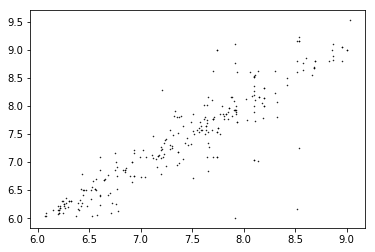

In [15]:
plot(zip(preds1,pvals))

### Model 2 - using Morgan Fingerprints

In [16]:
from rdkit.Chem import AllChem
morgan_fps = [AllChem.GetMorganFingerprintAsBitVect(m[0], 2, nBits=512) for m in train]

In [17]:
model2 = ensemble.RandomForestRegressor()
model2.fit(morgan_fps, pvals)
preds2 = model2.predict(morgan_fps)

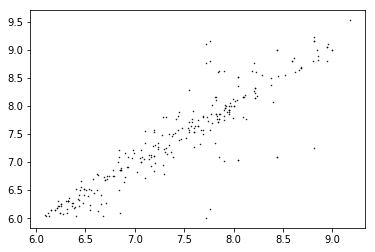

In [18]:
plot(zip(preds2,pvals))

## Testing models on test set

In [19]:
mqns_test = [rdMolDescriptors.MQNs_(m[0]) for m in test]
vals_test = [m[1] for m in test]
morgan_fps_test = [AllChem.GetMorganFingerprintAsBitVect(m[0], 2, nBits=512) for m in test]
pvals_test = [s(val) for val in vals_test]

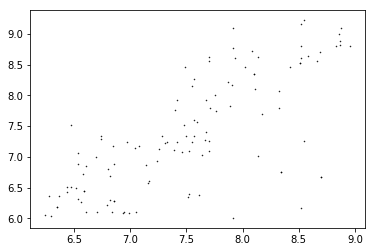

In [20]:
test_predictions1 = model1.predict(mqns_test)
plot(zip(test_predictions1, pvals_test))

In [21]:
print("R^2: %0.2f" % model1.score(mqns_test, pvals_test))
print("R: %0.2f" % np.sqrt(model1.score(mqns_test, pvals_test)))
print("MSE: %0.2f" %  mean_squared_error(model1.predict(mqns_test), pvals_test))

R^2: 0.50
R: 0.71
MSE: 0.43


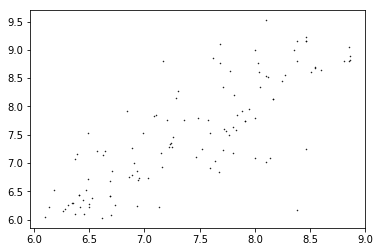

In [63]:
test_predictions2 = model2.predict(morgan_fps_test)
plot(zip(test_predictions2, pvals_test))

In [64]:
print("R^2: %0.2f" % model2.score(morgan_fps_test, pvals_test))
print("R: %0.2f" % np.sqrt(model2.score(morgan_fps_test, pvals_test)))
print("MSE: %0.2f" %  mean_squared_error(model2.predict(morgan_fps_test), pvals_test))

R^2: 0.63
R: 0.79
MSE: 0.34


# SVM Regression


In [22]:
clf = svm.SVR()
clf.fit(mqns, pvals)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

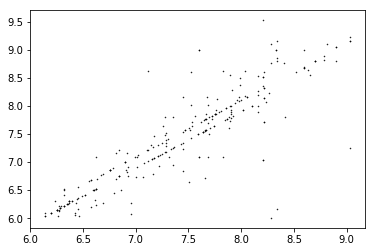

In [23]:
svm_preds1 = clf.predict(mqns)
plot(zip(svm_preds1,pvals))

### SMV model test

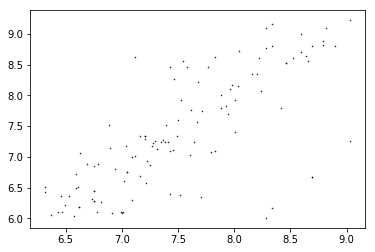

In [24]:
test_svm_preds1 = clf.predict(mqns_test)
plot(zip(test_svm_preds1,pvals_test))

In [25]:
print("R^2: %0.2f" % model2.score(morgan_fps_test, pvals_test))
print("R: %0.2f" % np.sqrt(model2.score(morgan_fps_test, pvals_test)))
print("MSE: %0.2f" %  mean_squared_error(model2.predict(morgan_fps_test), pvals_test))

R^2: 0.54
R: 0.73
MSE: 0.40


## Would the models be better if the molecules were rid of salts and inorganic structures?
#### Let's test it with random forest using morgan fingeprint

##### Remove inorganic structures

In [31]:
hasCarbonPatt = Chem.MolFromSmarts("[#6]")
onlyOrganicPatt = Chem.MolFromSmarts("[!#6;!#7;!#8;!#16;!F;!Cl;!Br;!I]")
mols_org = [[i for i in record] for record in active if \
                    (record[0].HasSubstructMatch(hasCarbonPatt) and not record[0].HasSubstructMatch(onlyOrganicPatt))]
len(active), len(mols_org)

(385, 370)

##### Remove salts

In [28]:
from rdkit.Chem.SaltRemover import SaltRemover

In [33]:
remover = SaltRemover()
mols_org_desalt = [remover(record[0]) for record in mols_org]

concentrations = [record[1] for record in mols_org]
mols_org_desalt = list(zip(mols_org_desalt, concentrations))

mols_org_desalt[:3]

[(<rdkit.Chem.rdchem.Mol at 0x1fa992d9940>, 2.8),
 (<rdkit.Chem.rdchem.Mol at 0x1fa9d1f0cb0>, 4.5),
 (<rdkit.Chem.rdchem.Mol at 0x1fa9d1f0440>, 5.5)]

In [57]:
split = int(len(mols_org_desalt)*0.7)
shuffle(mols_org_desalt)
train_f = mols_org_desalt[0:split] 
test_f = mols_org_desalt[split:]
len(train), len(test)

(259, 111)

##### Compute descriptors

In [58]:
morgan_fps_ftrain = [AllChem.GetMorganFingerprintAsBitVect(m[0], 2, nBits=512) for m in train_f]
morgan_fps_ftest = [AllChem.GetMorganFingerprintAsBitVect(m[0], 2, nBits=512) for m in test_f]
pvals_ftrain = [s(m[1]) for m in train_f]
pvals_ftest = [s(m[1]) for m in test_f]

## Filtered data model 1

In [59]:
f1 = ensemble.RandomForestRegressor()
f1.fit(morgan_fps_ftrain, pvals_ftrain)
preds_f1 = f1.predict(morgan_fps_ftrain)

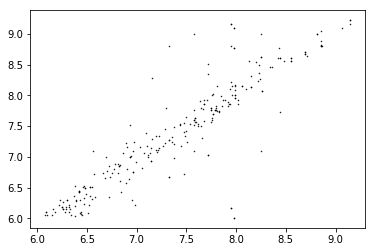

In [60]:
plot(zip(preds_f1,pvals_ftrain))

### Testing

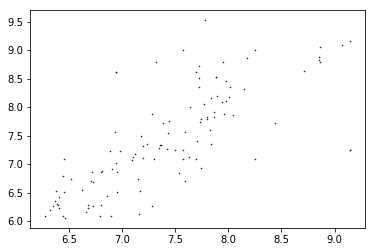

In [61]:
test_preds_f1 = f1.predict(morgan_fps_ftest)
plot(zip(test_preds_f1, pvals_ftest))

In [62]:
print("R^2: %0.2f" % model2.score(morgan_fps_test, pvals_test))
print("R: %0.2f" % np.sqrt(model2.score(morgan_fps_test, pvals_test)))
print("MSE: %0.2f" %  mean_squared_error(model2.predict(morgan_fps_test), pvals_test))

R^2: 0.54
R: 0.73
MSE: 0.40
